In [ ]:
from google.colab import files
files.upload() #kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d sukhmandeepsinghbrar/car-price-prediction-dataset
!unzip car-price-prediction-dataset.zip 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [ ]:
#loading the data and partial cleanup
df = pd.read_csv("cardekho.csv").dropna();

#df = df.rename(columns={"engine": 'Engine_Size', 'km_driven': 'Mileage', "selling_price" : "Price", "year": "Year",'fuel':"Fuel_Type", 'transmission':"Transmission", 'owner':"Owner", "max_power": "Max_Power"});
df['brand'] = df['name'].str.split(' ').str[0]
df['model'] = df['name'].str.split(' ').str[1:].str.join(' ')
df = df.drop(columns = ["mileage(km/ltr/kg)","name","seller_type","seats"])
df = df.iloc[::4]
df.columns = df.columns.str.replace(" ", "_") # adjusting column names
display(df.head())      # first 5 rows
df.shape                 # how many rows x columns
df.info()                # data types + non-null counts
df.describe().T          # summary statistics for numeric features


,year,selling_price,km_driven,fuel,transmission,owner,engine,max_power,brand,model
0,2014,450000,145500,Diesel,Manual,First Owner,1248.0,74,Maruti,Swift Dzire VDI
4,2007,130000,120000,Petrol,Manual,First Owner,1298.0,88.2,Maruti,Swift VXI BSIII
8,2011,350000,90000,Diesel,Manual,First Owner,1364.0,67.1,Toyota,Etios VXD
12,2009,280000,140000,Diesel,Manual,Second Owner,1248.0,73.9,Maruti,Swift Dzire VDi
17,2012,500000,53000,Diesel,Manual,Second Owner,1396.0,90,Hyundai,i20 1.4 CRDi Asta


<class 'pandas.core.frame.DataFrame'>
Index: 1977 entries, 0 to 8125
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           1977 non-null   int64  
 1   selling_price  1977 non-null   int64  
 2   km_driven      1977 non-null   int64  
 3   fuel           1977 non-null   object 
 4   transmission   1977 non-null   object 
 5   owner          1977 non-null   object 
 6   engine         1977 non-null   float64
 7   max_power      1977 non-null   object 
 8   brand          1977 non-null   object 
 9   model          1977 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 169.9+ KB


,count,mean,std,min,25%,50%,75%,max
year,1977.0,2014.178048,3.720724,1994.0,2012.0,2015.0,2017.0,2020.0
selling_price,1977.0,647419.284269,811289.418148,40000.0,270000.0,455000.0,680000.0,10000000.0
km_driven,1977.0,67911.105210,46676.376557,1.0,35000.0,60000.0,90000.0,500000.0
engine,1977.0,1452.155792,496.004211,624.0,1197.0,1248.0,1582.0,3604.0


## Price distribution

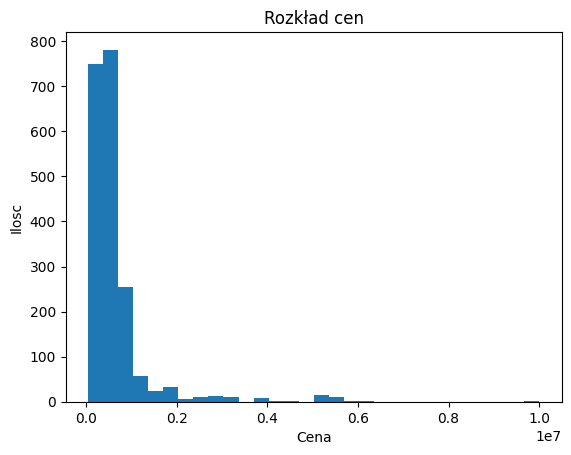

In [3]:
plt.hist(df["selling_price"], bins=30)
plt.title("Rozkład cen")
plt.xlabel("Cena")
plt.ylabel("Ilosc")
plt.show()

## Category features counts

In [4]:
print(df["fuel"].value_counts())
print(df["transmission"].value_counts())
print(df["owner"].value_counts())

fuel
Diesel    1066
Petrol     888
CNG         14
LPG          9
Name: count, dtype: int64
transmission
Manual       1739
Automatic     238
Name: count, dtype: int64
owner
First Owner             1329
Second Owner             491
Third Owner              122
Fourth & Above Owner      32
Test Drive Car             3
Name: count, dtype: int64


## Correlation heatmap for numeric features


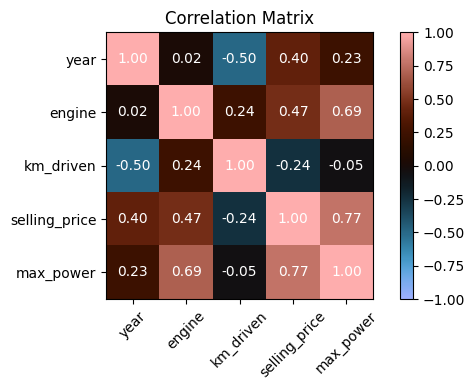

In [5]:
numeric_cols = ["year", "engine", "km_driven", "selling_price","max_power"]
corr = df[numeric_cols].corr()
plt.figure(figsize=(6,4))
plt.imshow(corr, cmap="berlin", vmin=-1, vmax=1)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.yticks(range(len(numeric_cols)), numeric_cols)
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}", ha="center", va="center", color="white")
plt.title("Correlation Matrix")
plt.colorbar()
plt.tight_layout()
plt.show()

In [19]:
X = df.drop(columns=["selling_price"]) 
y = df["selling_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42) # train/test split

In [ ]:
numeric_features = ["year", "engine", "km_driven","max_power"]
categorical_features = ["brand", "fuel", "transmission",  "model","owner"] # "Condition",

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

## Baseline models

### Random Forest Baseline

In [21]:
rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("rf", RandomForestRegressor(random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)


### SVR baseline

In [22]:
svr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("svr", SVR(kernel="rbf"))
])
svr_pipeline.fit(X_train, y_train)
y_pred_svr = svr_pipeline.predict(X_test)

### MLPRegressor baseline

In [23]:
mlp_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("mlp", MLPRegressor(random_state=42, solver="adam", early_stopping=True))
    #("mlp", MLPRegressor(random_state=42, solver="lbfgs", max_iter=1000))
])
mlp_pipeline.fit(X_train, y_train)
y_pred_mlp = mlp_pipeline.predict(X_test)

### Baseline evaluation

In [24]:
def evaluate(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred) # mean absolute error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # root mean squared error
    r2 = r2_score(y_true, y_pred) # r2 score
    return pd.Series([name, mae, rmse, r2], index=["Model", "MAE", "RMSE", "R2"])

results = pd.DataFrame([
    evaluate("RandomForest(default)", y_test, y_pred_rf),
    evaluate("SVR(default)",        y_test, y_pred_svr),
    evaluate("MLP(default)",        y_test, y_pred_mlp)
])
display(results)

,Model,MAE,RMSE,R2
0,RandomForest(default),89611.088193,193713.442145,0.934392
1,SVR(default),385311.455342,780249.826848,-0.064396
2,MLP(default),647050.435115,995303.478081,-0.731996


## Hyperparameter tuning

In [25]:
param_grids = {
    "rf": {
        "rf__n_estimators": [200],                
        "rf__max_depth": [None, 15],              
        "rf__min_samples_leaf": [1, 2],          
        "rf__max_features": ["sqrt", 0.5]        

    },
    "svr": {
        "svr__kernel": ["linear", "rbf"],
        "svr__C": [0.1, 1, 10, 100],
        "svr__gamma": [0.01, 0.1, 1, "scale", "auto"]
    },
    "mlp": {
        "mlp__hidden_layer_sizes": [(64,), (128,64)],
        "mlp__activation": ["relu", "tanh"],
        "mlp__alpha": [1e-3, 1e-4],
        "mlp__learning_rate_init": [0.001, 0.01],
        "mlp__solver": ["adam", "lbfgs"],
        "mlp__early_stopping": [True]
    }
}

searches = {}

### Random Forest search

In [26]:
searches["rf_search"] = GridSearchCV(
    rf_pipeline,
    param_grid=param_grids["rf"],
    cv=5, # 5-fold cross-validation
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

### SVR search

In [27]:
searches["svr_search"] = GridSearchCV(
    svr_pipeline,
    param_grid=param_grids["svr"],
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

### MLP search

In [28]:
searches["mlp_search"] = GridSearchCV(
    mlp_pipeline,
    param_grid=param_grids["mlp"],
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

### Running the searches

In [29]:
searches["rf_search"].fit(X_train, y_train);
searches["svr_search"].fit(X_train, y_train);
searches["mlp_search"].fit(X_train, y_train);

best_rf = searches["rf_search"].best_estimator_
best_svr = searches["svr_search"].best_estimator_
best_mlp = searches["mlp_search"].best_estimator_

/Users/olek/Documents/dl/ml/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/olek/Documents/dl/ml/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/olek/Documents/dl/ml/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning:

In [30]:
final_results = []
for name, model in [("RF_tuned", best_rf),
                    ("SVR_tuned", best_svr),
                    ("MLP_tuned", best_mlp)]:
    y_pred = model.predict(X_test)
    final_results.append(evaluate(name, y_test, y_pred))

display(pd.DataFrame(final_results).sort_values("RMSE"))

,Model,MAE,RMSE,R2
2,MLP_tuned,80531.936285,142118.109025,0.964687
0,RF_tuned,86202.134028,182532.503892,0.941747
1,SVR_tuned,279862.991424,668659.892894,0.218289


In [31]:
# Step 1: Evaluate default models
rf_default = evaluate("RandomForest", y_test, y_pred_rf)
svr_default = evaluate("SVR", y_test, y_pred_svr)
mlp_default = evaluate("MLP", y_test, y_pred_mlp)

# Step 2: Evaluate tuned models
rf_tuned = evaluate("RandomForest", y_test, best_rf.predict(X_test))
svr_tuned = evaluate("SVR", y_test, best_svr.predict(X_test))
mlp_tuned = evaluate("MLP", y_test, best_mlp.predict(X_test))


comparison_df = pd.DataFrame({
    "Model": ["RandomForest", "SVR", "MLP"],
    
    "MAE_default": [round(rf_default["MAE"]), round(svr_default["MAE"]), round(mlp_default["MAE"])],
    "MAE_tuned": [round(rf_tuned["MAE"]), round(svr_tuned["MAE"]), round(mlp_tuned["MAE"])],
    "MAE_diff": [round(rf_default["MAE"] - rf_tuned["MAE"]),
                 round(svr_default["MAE"] - svr_tuned["MAE"]),
                 round(mlp_default["MAE"] - mlp_tuned["MAE"])],
    "MAE_%diff": [round((rf_default["MAE"] - rf_tuned["MAE"]) / rf_default["MAE"] * 100, 2),
                  round((svr_default["MAE"] - svr_tuned["MAE"]) / svr_default["MAE"] * 100, 2),
                  round((mlp_default["MAE"] - mlp_tuned["MAE"]) / mlp_default["MAE"] * 100, 2)],

    "RMSE_default": [round(rf_default["RMSE"]), round(svr_default["RMSE"]), round(mlp_default["RMSE"])],
    "RMSE_tuned": [round(rf_tuned["RMSE"]), round(svr_tuned["RMSE"]), round(mlp_tuned["RMSE"])],
    "RMSE_diff": [round(rf_default["RMSE"] - rf_tuned["RMSE"]),
                  round(svr_default["RMSE"] - svr_tuned["RMSE"]),
                  round(mlp_default["RMSE"] - mlp_tuned["RMSE"])],
    "RMSE_%diff": [round((rf_default["RMSE"] - rf_tuned["RMSE"]) / rf_default["RMSE"] * 100, 2),
                   round((svr_default["RMSE"] - svr_tuned["RMSE"]) / svr_default["RMSE"] * 100, 2),
                   round((mlp_default["RMSE"] - mlp_tuned["RMSE"]) / mlp_default["RMSE"] * 100, 2)],

    "R2_default": [(rf_default["R2"]), (svr_default["R2"]), (mlp_default["R2"])],
    "R2_tuned": [(rf_tuned["R2"]), (svr_tuned["R2"]), (mlp_tuned["R2"])],
    "R2_diff": [(rf_tuned["R2"] - rf_default["R2"]),
                (svr_tuned["R2"] - svr_default["R2"]),
                (mlp_tuned["R2"] - mlp_default["R2"])],
    "R2_%diff": [round((rf_tuned["R2"] - rf_default["R2"]) / abs(rf_default["R2"]) * 100, 2),
                 round((svr_tuned["R2"] - svr_default["R2"]) / abs(svr_default["R2"]) * 100, 2),
                 round((mlp_tuned["R2"] - mlp_default["R2"]) / abs(mlp_default["R2"]) * 100, 2)],
})


display(comparison_df)


,Model,MAE_default,MAE_tuned,MAE_diff,MAE_%diff,RMSE_default,RMSE_tuned,RMSE_diff,RMSE_%diff,R2_default,R2_tuned,R2_diff,R2_%diff
0,RandomForest,89611,86202,3409,3.80,193713,182533,11181,5.77,0.934392,0.941747,0.007355,0.79
1,SVR,385311,279863,105448,27.37,780250,668660,111590,14.30,-0.064396,0.218289,0.282685,438.98
2,MLP,647050,80532,566518,87.55,995303,142118,853185,85.72,-0.731996,0.964687,1.696683,231.79
